# Objective of this Notebook
This notebook uses the dataset provided by kaggle for a competition called : Don't Overfit! II. 

Kagle provides a test set and a very small training set, which will encourage our model to overfit.

So we have to avoid overfitting and propose a model which can generalize to new examples coming from the test set.

# Table of contents
- [1. Data Exploration](#1-data-exploration)
  * [Reading data](#reading-data1)
  * [Features types](#features-types)
  * [Missing values](#missing-values1)
  * [Target classes repartition](#target-classes-repartition)
- [2. Data preprocessing](#2-data-preprocessing1)
  * [Feature scaling](#feature-scaling)
- [3. Logistic Regression](#3-logistic-regression)
  * [Model definition](#model-definition)
  * [Training, validation and evaluation](#training--validation-and-evaluation)
  * [Learning curves](#learning-curves)
- [4. Results Interpretation](#4-results-interpretation)
  * [Learning curve interpretation](#learning-curve-interpretation)
  * [F1 scores interpretation](#f1-scores-interpretation)
  * [Conclusion of the interpretations](#conclusion-of-the-interpretations)
  * [What can we do to reduce overfitting ?](#what-can-we-do-to-reduce-overfitting--)
- [5a. Feature Selection](#5a-feature-selection)
  * [Pearson correlation between features](#pearson-correlation-between-features)
  * [Selection process](#selection-process)
  * [Plotting costs differences VS number of features](#plotting-costs-differences-vs-number-of-features)
    + [Results Interpretations](#results-interpretations)
  * [Plotting training/validation costs VS number of features](#plotting-training-validation-costs-vs-number-of-features)
  * [Training of the new model](#training-of-the-new-model)
  * [Old model F1 score VS New model F1 score](#old-model-f1-score-vs-new-model-f1-score)
- [5b. Regularization](#5b-regularization)
  * [LASSO (l1 regularization)](#lasso--l1-regularization-)
  * [RIDGE (l2 regularization)](#ridge--l2-regularization-)
  * [Differences Lasso and Ridge regularization](#differences-lasso-and-ridge-regularization)
  * [Results interpretations](#results-interpretations2)

## 1. Data Exploration
<a id='1-data-exploration'></a>

### Reading data
<a id='reading-data1'></a>

In [1]:
import pandas as pd
import os

In [2]:
training_set = pd.read_csv('train.csv')
test_set = pd.read_csv('test.csv')
training_set.head()

,id,target,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,0,1.0,-1.067,-1.114,-0.616,0.376,1.090,0.467,-0.422,0.460,...,0.220,-0.339,0.254,-0.179,0.352,0.125,0.347,0.436,0.958,-0.824
1,1,0.0,-0.831,0.271,1.716,1.096,1.731,-0.197,1.904,-0.265,...,-0.765,-0.735,-1.158,2.554,0.856,-1.506,0.462,-0.029,-1.932,-0.343
2,2,0.0,0.099,1.390,-0.732,-1.065,0.005,-0.081,-1.450,0.317,...,-1.311,0.799,-1.001,1.544,0.575,-0.309,-0.339,-0.148,-0.646,0.725
3,3,1.0,-0.989,-0.916,-1.343,0.145,0.543,0.636,1.127,0.189,...,-1.370,1.093,0.596,-0.589,-0.649,-0.163,-0.958,-1.081,0.805,3.401
4,4,0.0,0.811,-1.509,0.522,-0.360,-0.220,-0.959,0.334,-0.566,...,-0.178,0.718,-1.017,1.249,-0.596,-0.445,1.751,1.442,-0.393,-0.643


### Features types
<a id='features-types'></a>

In [3]:
set(training_set.dtypes.values)

{dtype('int64'), dtype('float64')}

We only have numerical features, we can perform regression (linear or logistic)


### Missing values
<a id='missing-values1'></a>

In [4]:
training_set.isnull().any().any()

False

The False boolean tells us that we have no missing values.

### Target classes repartition
<a id='target-classes-repartition'></a>

In [5]:
print(training_set['target'].value_counts(),'\n')

class0_total = training_set['target'].value_counts()[0]
class1_total = training_set['target'].value_counts()[1]
total =  class1_total + class0_total
print('Percentage of class 0:',(class0_total / total)*100, "%")
print('Percentage of class 1:',(class1_total / total)*100, "%")

0.0    183
1.0     67
Name: target, dtype: int64 

Percentage of class 0: 73.2 %
Percentage of class 1: 26.8 %


Given that the class 0 is much more present than the class 1, we are in an imbalanced case. 
Thus, later, when we'll evaluate our model, we should use an appropriate metric of evaluation for skewed classes.
We could use **precision**, **recall** and finally compute the **F1 score**

## 2. Data preprocessing
<a id='2-data-preprocessing1'></a>
### Feature scaling
<a id='feature-scaling'></a>

Our linear model uses Gradient Descent to minimize a cost function.
We can speed up gradient descent by having each of our input values in roughly the same range.
Two techniques to help with this are feature scaling and mean normalization. 

* Feature scaling involves dividing the input values by the range (i.e. the maximum value minus the minimum value) of the input variable, resulting in a new range of just 1. 

* Mean normalization involves subtracting the average value for an input variable from the values for that input variable resulting in a new average value for the input variable of just zero. 

-> To implement both of these techniques, we can adjust our input values as shown in this formula:
$Z = \frac{x - \mu}{\sigma}$ where x is the feature value, $\mu$ is the average of all the values for the feature concerned and $\sigma$ is the standard deviation (or the range value : max-min)


Here the features are transformed so that they have the properties of a standard normal distribution  with mean = 0 and standard deviation = 1.
This will speed up calcultations of algorithms using Gradient Descent and measures of distance (like Euclidean distance).

In [6]:
training_set.agg([min, max])

,id,target,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
min,0,0.0,-3.181,-3.041,-2.967,-2.898,-2.837,-3.831,-2.873,-2.489,...,-2.824,-2.971,-3.592,-3.071,-2.621,-3.013,-3.275,-2.665,-3.006,-2.471
max,249,1.0,2.347,3.138,2.609,2.590,2.413,2.687,2.793,3.766,...,2.773,2.701,3.193,4.280,2.716,3.074,2.626,2.388,2.730,3.401


In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

#Features column names without the target 'target' 
features_columns_names = training_set.columns[:-1]
scaled_data = scaler.fit_transform(training_set[features_columns_names])

#Replacing features old values with their scaled values
training_set.loc[:, features_columns_names] = scaled_data

## 3. Logistic Regression
<a id='3-logistic-regression'></a>
### Model definition
<a id='model-definition'></a>


In [8]:
from sklearn.model_selection import train_test_split 

training_targets = training_set['target']
training_predictors = training_set.drop(columns='target')

X_train, X_val, y_train, y_val = train_test_split(training_predictors, training_targets, test_size=0.30, random_state=42, shuffle=True, 
                                                    stratify=training_targets)

y_train = y_train.astype(int)
y_val =y_val.astype(int)


In [9]:
from sklearn.linear_model import LogisticRegression

logistic_regression_model =LogisticRegression()

### Training, validation and evaluation
<a id='training--validation-and-evaluation'></a>

In [10]:
from sklearn.metrics import log_loss
import numpy as np

#To split the training set in 50 parts of same size
instance_sizes = np.linspace(0.05, 1.0, 50)
train_sizes = [int(i*X_train.shape[0]) for i in instance_sizes]

logloss_training_values = []
logloss_validationumbers_of_features = []
test_predictions = []
for i in range(len(instance_sizes)):
    logistic_model = logistic_regression_model
        
    #Training part
    training_predictors = X_train.iloc[:train_sizes[i]]
    training_outputs = y_train.iloc[:train_sizes[i]]
    training_outputs = training_outputs.values.astype(int)
    
    logistic_model = logistic_model.fit(training_predictors , training_outputs)
    training_predictions = logistic_model.predict(training_predictors)
    logloss_training_values.append(log_loss(training_outputs,training_predictions))
        
        
    #Test on validation set part
    val_predictions = logistic_model.predict(X_val)
    val_outputs = y_val.values
    logloss_validationumbers_of_features.append(log_loss(val_outputs, val_predictions))
    
    test_predictions = logistic_model.predict(test_set.values).astype(int)
    #print('size:',train_sizes[i],'preds:',test_predictions)
    
    
oldmodel_val_predictions = val_predictions


### Learning curves 
<a id='learning-curves'></a>

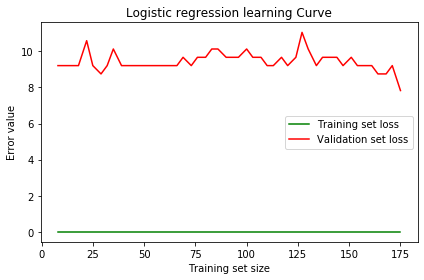

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

plt.plot(train_sizes,logloss_training_values, color="green", label="Training set loss")
plt.plot(train_sizes,logloss_validationumbers_of_features, color="red",  label="Validation set loss")


# Create plot
plt.title("Logistic regression learning Curve")
plt.xlabel("Training set size"), plt.ylabel("Error value"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [12]:
print("Training F1-score:", f1_score(training_outputs, training_predictions))
print("Validation F1-score:", f1_score(val_outputs, val_predictions))

Training F1-score: 1.0
Validation F1-score: 0.41379310344827586


## 4. Results Interpretation
<a id='4-results-interpretation'></a>

### Learning curve interpretation
<a id='learning-curve-interpretation'></a>
Plotting learning curves could be a good way to check if our model is doing good.
The loss value is very close to 0 for the training set compared to the loss for the validation set.

### F1 scores interpretation
<a id='f1-scores-interpretation'></a>
Given that the target classes are skewed (as seen on the 'Target classes repartition' part) , we'll use the F1 score , an appropriate metric when target classes proportions are imbalanced.

The relative contribution of precision and recall to the F1 score are equal. 

The formula for the F1 score is:
$$F1 = 2 * \frac{(precision * recall)}{(precision + recall)}$$

The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its **best value at 1** and **worst score at 0**.


**The F1-score reaches its best value of 1.0 for the training set but reaches 0.41 for the validation set, which is much lower.**

### Conclusion of the interpretations
<a id='conclusion-of-the-interpretations'></a>
We can see that our model has a high variance of performance between the training set and the validation set.
**Our model is overfitting the training set and can't generalize to new examples coming from the validation set.**

### What can we do to reduce overfitting ?
<a id='what-can-we-do-to-reduce-overfitting--'></a>
To prevent or reduce overfitting there are several options for us:
* Use regularization techniques
* Feature selection : choose a smaller subset of features

## 5a. Feature Selection
<a id='5a-feature-selection'></a>
### Pearson correlation between features
<a id='pearson-correlation-between-features'></a>

Pearson’s correlation coefficient is a statistical test which measures the statistical relationship, or association, between two continuous variables.  It is known as the best method of measuring the association between variables of interest because it is based on the method of covariance.  It gives information about the magnitude of the association, or correlation, as well as the direction of the relationship.

A Pearson correlation is a number between -1 and 1.
Features highly correlated (close to 1 or -1) with our target 'quality' will be helpful for the predictions of the latter.
If a feature has a correlation value close to 0, we can assume that they will be less useful regarding predictions of our target.

Let's analyze features correlation with our target to spot which features seems useful for prediction.

In [13]:
import seaborn as sns

correlations = training_set.corr()['target'].drop('target').abs().sort_values(ascending=False)
correlations

127    0.337540
176    0.217100
18     0.206452
59     0.203166
135    0.179960
         ...   
108    0.001018
111    0.000971
246    0.000778
263    0.000624
269    0.000211
Name: target, Length: 301, dtype: float64

There are a lot of features (300), we need to select a feature subset by looking at correlations with our target.

### Selection process
<a id='selection-process'></a>
We are trying to find the best number of features to select. Thus we will try differents values of 'n', the number of features selected (n most correlated features with the target).

Steps (of the code below):
* 1. We choose a number of feature n (between 1 and the total number of features)
* 2. We filter the training set and keep the n most correlated features
* 3. We fit our model to the training set and compute the loss regarding the training predictions
* 4. We use our trained model to predict outputs for the validation set and we compute its loss.
* 5. We store the losses, the difference between losses and the n values 


In [14]:
# returns the n more correlated (with the target) features 
def getNMostCorrelatedFeatures(n,correlations):
    colnames_and_correlation = [ [correlations.keys()[i],correlations.values[i]] for i in range (len(correlations.values))]
    return [colnames_and_correlation[i][0] for i in range(n) ]


training_loglosses = []
val_loglosses = []
train_val_cost_differences=[]
numbers_of_features = []

for n in range (1,len(X_train.columns)):
    selected_features = getNMostCorrelatedFeatures(n,correlations)
    logistic_model = LogisticRegression()
    
    #Training
    logistic_model = logistic_model.fit(X_train[selected_features] , y_train)
    train_predictions = logistic_model.predict(X_train[selected_features])
    train_loss = log_loss(y_train.values, train_predictions)
    
    #Predictions on the validation set
    val_predictions = logistic_model.predict(X_val[selected_features])
    val_outputs = y_val.values
    val_loss = log_loss(val_outputs, val_predictions)
    
    #Storing results on different lists (results used for plot later)
    training_loglosses.append(train_loss)
    val_loglosses.append(val_loss)
    train_val_cost_differences.append(abs(train_loss - val_loss))
    numbers_of_features.append(n)



### Plotting costs differences VS number of features
<a id='plotting-costs-differences-vs-number-of-features'></a>

Selection process
Let's plot the **difference between training cost and test cost** with respect to the number of features selected.

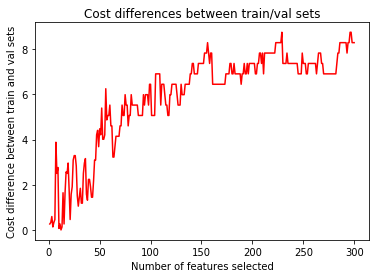

In [15]:
plt.plot(numbers_of_features,train_val_cost_differences,color="red",linestyle='-', label="Difference of loss between sets")
plt.title("Cost differences between train/val sets")
plt.xlabel("Number of features selected"), plt.ylabel("Cost difference between train and val sets"), 
plt.show()

In [16]:
from scipy import stats
corr,p_value = stats.pearsonr(numbers_of_features, train_val_cost_differences)
print('Correlation:',corr, ' and p-value:',p_value)

Correlation: 0.8510006268682806  and p-value: 2.410172810260306e-85


#### Results Interpretations
<a id='results-interpretations'></a>


The curve is telling us that the more we select correlated features with our target, the more difference we will have between the cost on the training set and the cost on the validation set. The pearson correlation is telling us that there is a **high positive value of linear correlation between both variables.** In other words, if we increase the number of features variable, the cost difference will increase too. 

Thus, the variance of performance between the training and the validation set will increase if we increase the number of feature selected. 
The more variance of performance we have, the more overfitted is our model and that's not what we want.

### Plotting training/validation costs VS number of features
<a id='plotting-training-validation-costs-vs-number-of-features'></a>

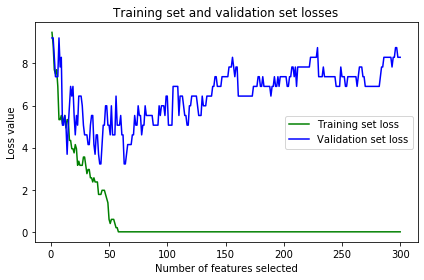

In [17]:
plt.plot(numbers_of_features,training_loglosses, color="green", label="Training set loss")
plt.plot(numbers_of_features,val_loglosses, color="blue",  label="Validation set loss")

# Create plot
plt.title("Training set and validation set losses")
plt.xlabel("Number of features selected"), plt.ylabel("Loss value"),plt.legend(loc="best")
plt.tight_layout()
plt.show()

When analyzing both curves we can see that **when the number of features selected exceed 50 the training cost reaches 0 and the validation cost increases**. When the training cost reaches a plateau at 0 and the validation cost increases, the variance regarding performance increases.

We should select a number n of features lower than 50. The value of n should :
* minimize the validation cost function
* and minimize the cost difference between training and validation.

Thus we will have a smaller variance between both sets with a reasonable cost compared to the overfitted model we had before.
The red point on the plot seems to be a reasonable choice because it represents the lowers validation loss and the cost difference seems low.

In [18]:
def getBestNbOfFeaturesIndex(number_of_features_values, validation_losses, cost_differences):
    weighted_averages = []
    for i in range (len(validation_losses)):
        train_val_difference = cost_differences[i]
        val_loss = validation_losses[i]
        weighted_average = ( (4*val_loss) + train_val_difference) / 2
        weighted_averages.append(weighted_average)
    
    min_average_index = weighted_averages.index(min(weighted_averages))
    return number_of_features_values[min_average_index]
    
number_of_features_toselect = getBestNbOfFeaturesIndex(numbers_of_features,val_loglosses,train_val_cost_differences)
print("The best value n (number of features selected) which minimize the validation cost function and the cost difference between training and validation is",number_of_features_toselect,'.')
print("We will select the",number_of_features_toselect,"most correlated features with our target." )

The best value n (number of features selected) which minimize the validation cost function and the cost difference between training and validation is 42 .
We will select the 42 most correlated features with our target.


### Training of the new model 
<a id='training-of-the-new-model'></a>
Let's train our new model and make predictions on the validation set.

In [19]:
selected_features = getNMostCorrelatedFeatures(number_of_features_toselect,correlations)
new_model = LogisticRegression()
    
#Training
new_model = new_model.fit(X_train[selected_features] , y_train)
newmodel_val_predictions = new_model.predict(X_val[selected_features])


### Old model F1 score VS New model F1 score
<a id='old-model-f1-score-vs-new-model-f1-score'></a>


In [20]:
print("Old model Validation F1-score:", f1_score(y_val.values, oldmodel_val_predictions))
print("New model Validation F1-score:", f1_score(y_val.values, newmodel_val_predictions))

Old model Validation F1-score: 0.41379310344827586
New model Validation F1-score: 0.8108108108108107


**By doing feature selection, we have a new model which is not overfitted and performs way better on the validation set than our old overfitted model.Our new model generalizes better to new examples which is a good point if we want our model to make good predictions on the test set.**

## Regularization
<a id='regularization'></a>

Regularization is another way like feature selection to deal with overfitting. We use a penalty to shrink (reduce) parameters values. The more complex becomes the model, the more sever/high is the penalty regarding parameters. All those parameters values will be reduced and the model will be less sensitive to parameters values helping for predictions. It is useful when we do not have a lot of data samples but many features.

We want the predictions to be less influenced by the training set because when we have a model which fits too well the training datapoint and perform badly on the validation set, we can say that the model is overfitting. Thus, we want to select a more biased model, a higher bias will result in a model which doesn't understand all the relationships between variables. This model will not overfit the training set and give also a better performance on the validation set than the previous overfitted model. We will have more consistent predictions which will result in a lower variance of performance between different data sets.

There are several techniques of regularization, we will try 2 of theme. 

* LASSO (Least Absolute Shrinkage and Selection Operator or L1 REGULARIZATION) 
* RIDGE Regularization (L2 REGULARIZATION) 

### LASSO (l1 regularization)
<a id='lasso--l1-regularization-'></a>

In [21]:
lasso_validation_losses = []
alphas = [0.01, 0.02,0.04,0.08,0.16,0.32,0.64,1.28,2.56,5.12,10.24]
predictions=[]
for alpha in alphas :
    model = LogisticRegression(solver='liblinear',penalty='l1', C=1/alpha)
    #Training
    model = model.fit(X_train , y_train)
    
    #Predictions on the validation set
    val_predictions = model.predict(X_val)
    predictions.append(val_predictions)
    val_outputs = y_val.values
    val_loss = log_loss(val_outputs, val_predictions)
 
    lasso_validation_losses.append(val_loss)


lowest_lasso_loss = min(lasso_validation_losses)
lowest_lasso_loss_index = lasso_validation_losses.index(lowest_lasso_loss)
best_lasso_alpha = alphas[lowest_lasso_loss_index]

print('Lowest Lasso loss:',lowest_lasso_loss,' given by alpha value:',best_lasso_alpha)

Lowest Lasso loss: 8.749844675975512  given by alpha value: 10.24


### RIDGE (l2 regularization)
<a id='ridge--l2-regularization-'></a>

In [22]:
ridge_validation_losses = []
predictions=[]
for alpha in alphas :
    model = LogisticRegression(solver='liblinear',penalty='l2', C=1/alpha)
    #Training
    model = model.fit(X_train , y_train)
    
    #Predictions on the validation set
    val_predictions = model.predict(X_val)
    predictions.append(val_predictions)
    val_outputs = y_val.values
    val_loss = log_loss(val_outputs, val_predictions)
 
    ridge_validation_losses.append(val_loss)

lowest_ridge_loss = min(ridge_validation_losses)
lowest_ridge_loss_index = ridge_validation_losses.index(lowest_ridge_loss)
best_ridge_alpha = alphas[lowest_ridge_loss_index]

print('Lowest Ridge loss:',lowest_ridge_loss,' given by alpha value:',best_ridge_alpha)

Lowest Ridge loss: 11.973634386952286  given by alpha value: 0.01


### Differences Lasso and Ridge regularization
<a id='differences-lasso-and-ridge-regularization'></a>
LASSO can make the slope  be equal to 0 so with that we can use it for feature selection when useless features with small values reach 0. Ridge will make the slope come close to 0 but never equal to 0. Thus LASSO is better at reducing the model variance when we have several useless features but Ridge is preferred when all those features matter and are interesting to keep.

### Results interpretations
<a id='results-interpretations2'></a>
In our case, there are several useless features which could be drop to reduce overfitting, we have seen this with feature selection. As explained in the previous part, LASSO will make some parameters of useless features, reach 0. So it will drop useless features. Using Logistic regression with Lasso gives a lower loss value compared to Logistic Regression with Ridge. For all these reasons, I think we can go with Lasso Regularization.